In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1200186111706324698]

In [4]:
df = pd.read_csv('data/medibloc(2018~2021).csv', encoding='cp949')
df.tail()

,날짜,시가,고가,저가,종가,거래량,시가총액
1090,30-Mar-21,102.73,119.43,102.72,111.63,"\229,362,666,554","\305,655,135,725"
1091,31-Mar-21,112.61,140.07,109.94,130.17,"\503,803,529,611","\356,424,611,490"
1092,01-Apr-21,130.17,277.06,127.18,273.11,"\2,256,586,556,340","\747,797,814,365"
1093,02-Apr-21,267.53,398.55,267.53,298.93,"\1,629,150,393,198","\818,506,251,680"
1094,03-Apr-21,299.90,327.75,272.89,286.96,"\586,518,672,303","\785,724,654,933"


In [5]:
# 종가 기준으로 구하기
prices = df['종가'].values

In [6]:
prices[-30:]

array([ 21.59,  20.85,  21.82,  22.87,  38.99,  36.64,  38.45,  40.57,
        49.31,  50.45,  48.36,  54.8 ,  57.07,  97.01, 104.02,  99.93,
       110.01, 102.34,  99.69,  93.82,  97.71,  99.43, 101.03,  99.74,
       102.74, 111.63, 130.17, 273.11, 298.93, 286.96])

In [7]:
# 최근 30일을 기준으로 다음날 가격을 예측을 위한 슬라이싱
seq_len = 30
squence_length = seq_len + 1
result = []
for i in range(len(prices) - squence_length):
    print(i)
    print(prices[i: i + squence_length])
    result.append(prices[i: i + squence_length])
result

0
[16.02 15.95 16.69 17.23 17.14 17.36 18.09 19.89 20.3  22.22 23.17 21.73
 21.24 22.7  22.86 29.46 38.69 39.37 38.58 41.83 35.17 38.33 39.85 40.86
 39.92 37.35 36.35 40.65 40.67 38.66 39.49]
1
[15.95 16.69 17.23 17.14 17.36 18.09 19.89 20.3  22.22 23.17 21.73 21.24
 22.7  22.86 29.46 38.69 39.37 38.58 41.83 35.17 38.33 39.85 40.86 39.92
 37.35 36.35 40.65 40.67 38.66 39.49 36.54]
2
[16.69 17.23 17.14 17.36 18.09 19.89 20.3  22.22 23.17 21.73 21.24 22.7
 22.86 29.46 38.69 39.37 38.58 41.83 35.17 38.33 39.85 40.86 39.92 37.35
 36.35 40.65 40.67 38.66 39.49 36.54 34.68]
3
[17.23 17.14 17.36 18.09 19.89 20.3  22.22 23.17 21.73 21.24 22.7  22.86
 29.46 38.69 39.37 38.58 41.83 35.17 38.33 39.85 40.86 39.92 37.35 36.35
 40.65 40.67 38.66 39.49 36.54 34.68 32.72]
4
[17.14 17.36 18.09 19.89 20.3  22.22 23.17 21.73 21.24 22.7  22.86 29.46
 38.69 39.37 38.58 41.83 35.17 38.33 39.85 40.86 39.92 37.35 36.35 40.65
 40.67 38.66 39.49 36.54 34.68 32.72 30.35]
5
[17.36 18.09 19.89 20.3  22.22 23.17 21

 5.49 5.42 5.35]
535
[3.78 3.6  3.56 3.41 3.33 3.35 3.37 3.54 3.44 3.5  3.61 3.58 3.82 3.66
 3.77 4.04 5.93 4.94 4.82 4.83 3.82 3.13 4.38 4.34 3.59 5.57 5.38 5.49
 5.42 5.35 5.06]
536
[3.6  3.56 3.41 3.33 3.35 3.37 3.54 3.44 3.5  3.61 3.58 3.82 3.66 3.77
 4.04 5.93 4.94 4.82 4.83 3.82 3.13 4.38 4.34 3.59 5.57 5.38 5.49 5.42
 5.35 5.06 4.42]
537
[3.56 3.41 3.33 3.35 3.37 3.54 3.44 3.5  3.61 3.58 3.82 3.66 3.77 4.04
 5.93 4.94 4.82 4.83 3.82 3.13 4.38 4.34 3.59 5.57 5.38 5.49 5.42 5.35
 5.06 4.42 4.63]
538
[3.41 3.33 3.35 3.37 3.54 3.44 3.5  3.61 3.58 3.82 3.66 3.77 4.04 5.93
 4.94 4.82 4.83 3.82 3.13 4.38 4.34 3.59 5.57 5.38 5.49 5.42 5.35 5.06
 4.42 4.63 4.61]
539
[3.33 3.35 3.37 3.54 3.44 3.5  3.61 3.58 3.82 3.66 3.77 4.04 5.93 4.94
 4.82 4.83 3.82 3.13 4.38 4.34 3.59 5.57 5.38 5.49 5.42 5.35 5.06 4.42
 4.63 4.61 4.65]
540
[3.35 3.37 3.54 3.44 3.5  3.61 3.58 3.82 3.66 3.77 4.04 5.93 4.94 4.82
 4.83 3.82 3.13 4.38 4.34 3.59 5.57 5.38 5.49 5.42 5.35 5.06 4.42 4.63
 4.61 4.65 4.79]
541
[

 4.84 5.49 5.37]
974
[5.7  5.97 5.85 6.03 5.66 5.81 5.62 5.36 5.53 5.57 5.72 5.56 5.36 5.4
 5.67 5.9  4.89 5.38 5.45 4.54 5.26 5.12 5.15 5.21 5.24 4.51 4.88 4.84
 5.49 5.37 3.22]
975
[5.97 5.85 6.03 5.66 5.81 5.62 5.36 5.53 5.57 5.72 5.56 5.36 5.4  5.67
 5.9  4.89 5.38 5.45 4.54 5.26 5.12 5.15 5.21 5.24 4.51 4.88 4.84 5.49
 5.37 3.22 5.28]
976
[5.85 6.03 5.66 5.81 5.62 5.36 5.53 5.57 5.72 5.56 5.36 5.4  5.67 5.9
 4.89 5.38 5.45 4.54 5.26 5.12 5.15 5.21 5.24 4.51 4.88 4.84 5.49 5.37
 3.22 5.28 5.69]
977
[6.03 5.66 5.81 5.62 5.36 5.53 5.57 5.72 5.56 5.36 5.4  5.67 5.9  4.89
 5.38 5.45 4.54 5.26 5.12 5.15 5.21 5.24 4.51 4.88 4.84 5.49 5.37 3.22
 5.28 5.69 5.52]
978
[5.66 5.81 5.62 5.36 5.53 5.57 5.72 5.56 5.36 5.4  5.67 5.9  4.89 5.38
 5.45 4.54 5.26 5.12 5.15 5.21 5.24 4.51 4.88 4.84 5.49 5.37 3.22 5.28
 5.69 5.52 4.78]
979
[5.81 5.62 5.36 5.53 5.57 5.72 5.56 5.36 5.4  5.67 5.9  4.89 5.38 5.45
 4.54 5.26 5.12 5.15 5.21 5.24 4.51 4.88 4.84 5.49 5.37 3.22 5.28 5.69
 5.52 4.78 4.35]
980
[5.

[array([16.02, 15.95, 16.69, 17.23, 17.14, 17.36, 18.09, 19.89, 20.3 ,
        22.22, 23.17, 21.73, 21.24, 22.7 , 22.86, 29.46, 38.69, 39.37,
        38.58, 41.83, 35.17, 38.33, 39.85, 40.86, 39.92, 37.35, 36.35,
        40.65, 40.67, 38.66, 39.49]),
 array([15.95, 16.69, 17.23, 17.14, 17.36, 18.09, 19.89, 20.3 , 22.22,
        23.17, 21.73, 21.24, 22.7 , 22.86, 29.46, 38.69, 39.37, 38.58,
        41.83, 35.17, 38.33, 39.85, 40.86, 39.92, 37.35, 36.35, 40.65,
        40.67, 38.66, 39.49, 36.54]),
 array([16.69, 17.23, 17.14, 17.36, 18.09, 19.89, 20.3 , 22.22, 23.17,
        21.73, 21.24, 22.7 , 22.86, 29.46, 38.69, 39.37, 38.58, 41.83,
        35.17, 38.33, 39.85, 40.86, 39.92, 37.35, 36.35, 40.65, 40.67,
        38.66, 39.49, 36.54, 34.68]),
 array([17.23, 17.14, 17.36, 18.09, 19.89, 20.3 , 22.22, 23.17, 21.73,
        21.24, 22.7 , 22.86, 29.46, 38.69, 39.37, 38.58, 41.83, 35.17,
        38.33, 39.85, 40.86, 39.92, 37.35, 36.35, 40.65, 40.67, 38.66,
        39.49, 36.54, 34.68, 32.72

In [8]:
# 정규화
normalized_data = []
for window in result:
    normalized_window = [((float(p)/float(window[0])) ) for p in window]   
    normalized_data.append(normalized_window)
result = np.array(normalized_data)

In [9]:
result[:,:-1], result[:,-1]

(array([[ 1.        ,  0.99563046,  1.04182272, ...,  2.53745318,
          2.53870162,  2.41323346],
        [ 1.        ,  1.04639498,  1.08025078, ...,  2.54984326,
          2.42382445,  2.47586207],
        [ 1.        ,  1.0323547 ,  1.02696225, ...,  2.3163571 ,
          2.36608748,  2.18933493],
        ...,
        [ 1.        ,  0.93648892,  1.20071899, ...,  5.97603355,
          6.15578191,  6.68843619],
        [ 1.        ,  1.28214971,  1.3378119 , ...,  6.57325656,
          7.14203455,  8.32821497],
        [ 1.        ,  1.04341317,  1.07734531, ...,  5.57035928,
          6.49550898, 13.62824351]]),
 array([ 2.4650437 ,  2.29090909,  2.07789095, ...,  7.79928101,
        17.4734485 , 14.91666667]))

In [10]:
#data split
row = int(round(result.shape[0]*0.8))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((851, 30, 1), (213, 30, 1))

In [11]:
x_test[0], y_test[0]

(array([[1.        ],
        [0.99408284],
        [0.98816568],
        [0.99211045],
        [0.99013807],
        [1.01380671],
        [1.0295858 ],
        [1.07100592],
        [1.01972387],
        [1.03747535],
        [1.0591716 ],
        [1.06311637],
        [1.06706114],
        [1.07100592],
        [1.06706114],
        [1.09270217],
        [1.0591716 ],
        [1.1025641 ],
        [1.06706114],
        [1.19329389],
        [1.13806706],
        [1.14990138],
        [1.13412229],
        [1.14595661],
        [1.08086785],
        [1.13412229],
        [1.14595661],
        [1.14398422],
        [1.10650888],
        [1.1025641 ]]),
 1.0946745562130176)

In [12]:
# LSTM  모델구현

model = Sequential()

model.add(LSTM(255,return_sequences=True, input_shape=(30,1)))

model.add(LSTM(64,return_sequences=False))

model.add(Dense(1,activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 255)           262140    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                81920     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 344,125
Trainable params: 344,125
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, verbose=1)

In [14]:
history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=20, epochs=100, callbacks=es)

Epoch 1/100
43/43 [==============================] - 7s 85ms/step - loss: 0.2461 - mae: 0.3312 - val_loss: 3.8726 - val_mae: 0.7393
Epoch 2/100
43/43 [==============================] - 1s 26ms/step - loss: 0.0349 - mae: 0.1379 - val_loss: 2.8764 - val_mae: 0.6605
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.0280 - mae: 0.1247 - val_loss: 2.7709 - val_mae: 0.5805
Epoch 4/100
43/43 [==============================] - 1s 26ms/step - loss: 0.0179 - mae: 0.0908 - val_loss: 2.4417 - val_mae: 0.5336
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.0196 - mae: 0.0990 - val_loss: 2.6530 - val_mae: 0.6996
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.0269 - mae: 0.1139 - val_loss: 2.0966 - val_mae: 0.4843
Epoch 7/100
43/43 [==============================] - 1s 25ms/step - loss: 0.0142 - mae: 0.0830 - val_loss: 2.0829 - val_mae: 0.4975
Epoch 8/100
43/43 [==============================] - 1s 25ms/step - loss: 0.

In [15]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 20ms/step - loss: 2.0045 - mae: 0.4863


[2.0044820308685303, 0.4863181710243225]

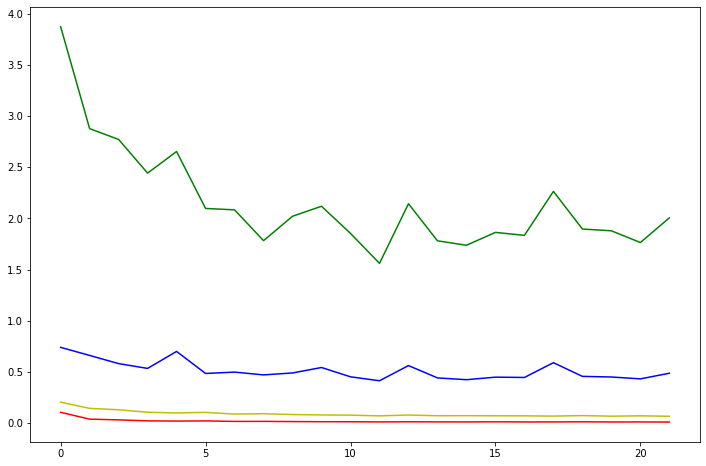

In [16]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], c='r')
plt.plot(history.history['val_loss'], c='g')
plt.plot(history.history['mae'], c='y' )
plt.plot(history.history['val_mae'], c='b')
plt.show()

In [37]:
x_test

array([[[ 1.        ],
        [ 0.99408284],
        [ 0.98816568],
        ...,
        [ 1.14398422],
        [ 1.10650888],
        [ 1.1025641 ]],

       [[ 1.        ],
        [ 0.99404762],
        [ 0.99801587],
        ...,
        [ 1.11309524],
        [ 1.10912698],
        [ 1.10119048]],

       [[ 1.        ],
        [ 1.00399202],
        [ 1.00199601],
        ...,
        [ 1.11576846],
        [ 1.10778443],
        [ 0.97005988]],

       ...,

       [[ 1.        ],
        [ 0.93648892],
        [ 1.20071899],
        ...,
        [ 5.97603355],
        [ 6.15578191],
        [ 6.68843619]],

       [[ 1.        ],
        [ 1.28214971],
        [ 1.3378119 ],
        ...,
        [ 6.57325656],
        [ 7.14203455],
        [ 8.32821497]],

       [[ 1.        ],
        [ 1.04341317],
        [ 1.07734531],
        ...,
        [ 5.57035928],
        [ 6.49550898],
        [13.62824351]]])

In [17]:
pred = model.predict(x_test)
pred

array([[1.0772275 ],
       [1.074824  ],
       [0.97616017],
       [0.98316854],
       [0.94085974],
       [0.9295863 ],
       [0.9040132 ],
       [0.8627398 ],
       [0.91256344],
       [0.9368601 ],
       [0.9287947 ],
       [0.9529286 ],
       [0.93133515],
       [0.93630296],
       [0.929724  ],
       [0.89932156],
       [0.9233766 ],
       [0.8970576 ],
       [0.9202016 ],
       [0.8134996 ],
       [0.83147216],
       [0.8213681 ],
       [0.8124075 ],
       [0.82309884],
       [0.9005454 ],
       [0.86443824],
       [0.8505815 ],
       [0.8544336 ],
       [0.8922176 ],
       [0.8985728 ],
       [0.9036146 ],
       [1.0041912 ],
       [0.9691087 ],
       [1.0229342 ],
       [1.0345284 ],
       [1.0449935 ],
       [1.126319  ],
       [1.1414253 ],
       [1.1214708 ],
       [1.0876462 ],
       [1.0361474 ],
       [1.1122458 ],
       [1.071895  ],
       [1.0796809 ],
       [1.0729386 ],
       [1.0703254 ],
       [1.089476  ],
       [1.105

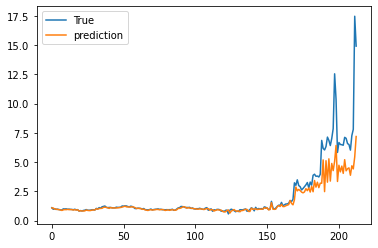

In [18]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(1,1,1)
ax.plot(y_test,label='True')
ax.plot(pred, label='prediction')
ax.legend()
plt.show()

In [30]:
r_price = [] 
r_price.append(prices[-30:])
r_price[0]

array([ 21.59,  20.85,  21.82,  22.87,  38.99,  36.64,  38.45,  40.57,
        49.31,  50.45,  48.36,  54.8 ,  57.07,  97.01, 104.02,  99.93,
       110.01, 102.34,  99.69,  93.82,  97.71,  99.43, 101.03,  99.74,
       102.74, 111.63, 130.17, 273.11, 298.93, 286.96])

In [36]:
p_price = []
    # 데이터 정규화
pre_test = []
normalized_window = [float(p)/float(r_price[0][0])for p in r_price[0]]
pre_test.append(normalized_window)
test = np.array(pre_test)
test
pre_test = test[:,:]
pre_test = np.reshape(pre_test, (pre_test.shape[0], pre_test.shape[1],1))
pre_test        

array([[[ 1.        ],
        [ 0.96572487],
        [ 1.01065308],
        [ 1.05928671],
        [ 1.80592867],
        [ 1.69708198],
        [ 1.78091709],
        [ 1.8791107 ],
        [ 2.28392774],
        [ 2.33672997],
        [ 2.23992589],
        [ 2.53821214],
        [ 2.6433534 ],
        [ 4.49328393],
        [ 4.81797128],
        [ 4.62853173],
        [ 5.09541454],
        [ 4.74015748],
        [ 4.61741547],
        [ 4.34553034],
        [ 4.52570635],
        [ 4.60537286],
        [ 4.67948124],
        [ 4.61973136],
        [ 4.75868458],
        [ 5.17044928],
        [ 6.02918018],
        [12.64983789],
        [13.84576193],
        [13.29133858]]])

In [38]:
# 미래 코인가격을 예측하는 함수
def predictCoin(prices):
    r_price = [] 
    r_price.append(prices[-30:])
    p_price = []
    for i in range(170):
        # 데이터 정규화
        pre_test = []
        normalized_window = [float(p)/float(r_price[i][0])for p in r_price[i]]
        pre_test.append(normalized_window)
        test = np.array(pre_test)
        pre_test = test[:,:]
        pre_test = np.reshape(pre_test, (pre_test.shape[0], pre_test.shape[1],1))
        # 가격 예측 후 원래 데이터셋에 추가(예측 가격은 p_price)
        pre_result = model.predict(pre_test)
        p = pre_result[0]
        p = round(r_price[i][0]*p[0],2)
        p_price.append(p)
        new_price = np.array([])
        new_price = np.append(r_price[i][1:],p)
        r_price.append(new_price)
        print(i)
    return r_price 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


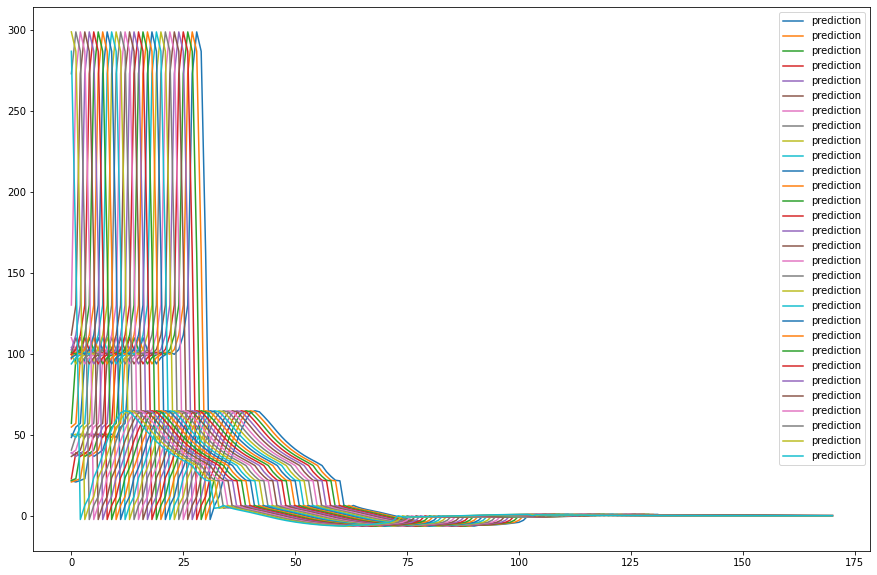

In [39]:
predictC = predictCoin(prices)

fig = plt.figure(facecolor='white',figsize=(15,10))
ax = fig.add_subplot(1,1,1)
ax.plot(predictC, label='prediction')
ax.legend()
plt.show()

In [40]:
predictC

[array([ 21.59,  20.85,  21.82,  22.87,  38.99,  36.64,  38.45,  40.57,
         49.31,  50.45,  48.36,  54.8 ,  57.07,  97.01, 104.02,  99.93,
        110.01, 102.34,  99.69,  93.82,  97.71,  99.43, 101.03,  99.74,
        102.74, 111.63, 130.17, 273.11, 298.93, 286.96]),
 array([ 20.85,  21.82,  22.87,  38.99,  36.64,  38.45,  40.57,  49.31,
         50.45,  48.36,  54.8 ,  57.07,  97.01, 104.02,  99.93, 110.01,
        102.34,  99.69,  93.82,  97.71,  99.43, 101.03,  99.74, 102.74,
        111.63, 130.17, 273.11, 298.93, 286.96, 162.03]),
 array([ 21.82,  22.87,  38.99,  36.64,  38.45,  40.57,  49.31,  50.45,
         48.36,  54.8 ,  57.07,  97.01, 104.02,  99.93, 110.01, 102.34,
         99.69,  93.82,  97.71,  99.43, 101.03,  99.74, 102.74, 111.63,
        130.17, 273.11, 298.93, 286.96, 162.03,  -2.33]),
 array([ 22.87,  38.99,  36.64,  38.45,  40.57,  49.31,  50.45,  48.36,
         54.8 ,  57.07,  97.01, 104.02,  99.93, 110.01, 102.34,  99.69,
         93.82,  97.71,  99.43, 10